# Guiding Quetions:
## 1. How does gdp growth affects a country's forest coverage? 
## 2. What are the best 3 and the worst 3 countries in each income level in term of GDP growth with respect to forest area changes? The worst 3 can learn from the best 3. 
## 3. What are the worst regions in term of deforestation?
## 4. What will be the size of  forest area of the worst country for next two years?


## Data Source: World Bank
1. NY.GDP.MKTP.CD     : GDP $
#### http://data.worldbank.org/indicator/NY.GDP.MKTP.CD
2. AG.LND.FRST.K2     : Forest area (sq km)
#### http://data.worldbank.org/indicator/AG.LND.FRST.K2
3. gdp_projection.csv : GDP forecast by World Bank(No API Aviailable)

## Youtube Link
https://youtu.be/ZNB_T8bvB-8

In [1]:
import pandas as pd
from pandas.io import wb
import pandas.rpy.common as com
import numpy as np
import MySQLdb as myDB
from rpy2.robjects.packages import importr
from rpy2 import robjects as ro
import rpy2.robjects.lib.ggplot2 as ggplot2
from rpy2.robjects.packages import importr
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from IPython.core.display import Image
import warnings
import os
warnings.simplefilter('ignore')
%matplotlib inline

/usr/local/lib/python2.7/dist-packages/pandas/rpy/__init__.py:11: FutureWarning: The pandas.rpy module is deprecated and will be removed in a future version. We refer to external packages like rpy2. 
See here for a guide on how to port your code to rpy2: http://pandas.pydata.org/pandas-docs/stable/r_interface.html
  FutureWarning)


### Obtaining Data


In [2]:
def getCountryMeta():
    """
    purpose: obtain iso meta data for country only
    """
    cntry_meta = wb.get_countries()
    cntry_only_meta = cntry_meta.ix[(cntry_meta["capitalCity"].isnull() == False) & (cntry_meta["capitalCity"] != '') ,:]
    cntry_only_meta = cntry_only_meta[['incomeLevel', 'iso3c','name']] 
    return cntry_only_meta

def getWBData(country_meta, indicators):
    """
    purpose: download world bank country only data
    {
        "country_meta": a data frame containing country meta data,
        "indicators":   a list containing data series indicators
        }
    """
    iso_3c = country_meta.iso3c
    #obtaining data
    gdp_forest = wb.download(indicator=indicators, country=iso_3c, start=1981, end = 2015)
    indexes = gdp_forest.index.values
    gdp_forest.columns = ['gdp', 'forest_area']
    df_wb=gdp_forest.reset_index()
    df_wb.sort(columns=['country','year'], inplace=True)
    df_wb['year'] = df_wb['year'].convert_objects(convert_numeric = True)
    return df_wb

indicators=["NY.GDP.MKTP.CD", 'AG.LND.FRST.K2']
country_meta = getCountryMeta()
df_wb = getWBData(country_meta, indicators)

### Cleaning Data

In [3]:
def handleMissingData(df_wb):
    """
        purpose: handle missing value 
        {
        "df_wb" : a data frame containing uncleaned data
        }
    """
    cnty_grp = df_wb.groupby('country')
    df_cleaned = pd.DataFrame()
    for name, grp in cnty_grp:
        g_copy = grp.copy() 
        g_copy.set_index('year', inplace=True)
        g_copy['gdp']= g_copy["gdp"].interpolate()
        g_copy['gdp']= g_copy["gdp"].fillna(method='ffill') #repalce nan forward
        g_copy['gdp']= g_copy["gdp"].fillna(method='bfill') #replace nan backward
        g_copy['gdp']= g_copy["gdp"] / (10**9) # changed to billions
        g_copy['gdp_angr'] = g_copy['gdp'].pct_change() # calculate growth rate 
        g_copy['gdp_angr'][0] = 0
        g_copy['forest_area']= g_copy["forest_area"].fillna(method='ffill')
        g_copy['forest_area']= g_copy["forest_area"].fillna(method='bfill')
        g_copy['forest_pct_chg'] = g_copy["forest_area"].pct_change()
        g_copy['forest_pct_chg'].fillna(0, inplace=True) 
        g_copy.reset_index(inplace=True)
        df_cleaned = df_cleaned.append(g_copy)
    return df_cleaned
    
wb_cleaned = handleMissingData(df_wb)
    

### Load to MYSQL

In [4]:
def write2Mysql(db, myTable, df, primary_keys):
    """
    purpose: save data to mysql database
    {
    "db":          a string for database name
    "myTable":     a string for table name
    "df":          a data frame for data
    "primary_keys: a string for primary keys
    }
    """
    con = myDB.connect(host='localhost', user='root', passwd='root')
    cursor = con.cursor()
    cursor.execute("Create Database if not exists " + db + ";") 
    con = myDB.connect(host='localhost', user='root', passwd='root', db=db) #open connection for database
    df.to_sql(myTable, con, flavor='mysql', if_exists='replace', index=False)
    cursor = con.cursor()
    sql = "Alter Table " + myTable + " add primary key(" + primary_keys + ");"
    cursor.execute(sql)
    con.close()
#write meta data to mysql
write2Mysql('ind_proj', 'cnty_meta',  country_meta,'iso3c')
write2Mysql('ind_proj', 'gdp_forest', wb_cleaned, 'year, country')
    

### Retrieve Data

In [5]:
def readMysql(sql,db):
    con = myDB.connect(host='localhost', user='root', passwd='root', db=db) #open connection for database
    df = pd.read_sql(sql, con)
    con.close()
    return df

sql = "Select c.name, c.incomeLevel, g.* from cnty_meta as c inner join gdp_forest as g on c.name = g.country order by c.name, g.year;"
gdp_forest = readMysql(sql, 'ind_proj')

### Simple plots to look at how world's gdp and forest area  changes 

In [6]:
grouped_by_year = gdp_forest.groupby('year')
gdp_and_forest_by_year = grouped_by_year[['gdp', 'forest_area']]
gdp_and_forest_total_by_year = gdp_and_forest_by_year.sum()
gdp_and_forest_total_by_year.reset_index(inplace=True)
r_gdp_and_forest_total = com.convert_to_r_dataframe(gdp_and_forest_total_by_year)

In [7]:
def createYearTotalPlot(data, x, y, ylabel, color, filename):
    gp = ggplot2.ggplot(data=data)
    gp = gp + \
    ggplot2.geom_line(ggplot2.aes_string(x=x, y=y), color=color) + \
    ggplot2.theme(**{'axis.text.x' : ggplot2.element_text(angle = 90, hjust = 1),
                      'strip.text.y' : ggplot2.element_text(size = 6, angle=90)})  + \
    ggplot2.scale_y_continuous(ylabel) 
    ggplot2.ggplot2.ggsave(filename, gp)
    
createYearTotalPlot(r_gdp_and_forest_total, 'year', 'gdp', "Annual GDP in Billions", 'steelblue', 'gdp_total_by_year.png')
createYearTotalPlot(r_gdp_and_forest_total, 'year', 'forest_area', "Forest Area in sq km", 'red', 'forest_total_by_year.png')

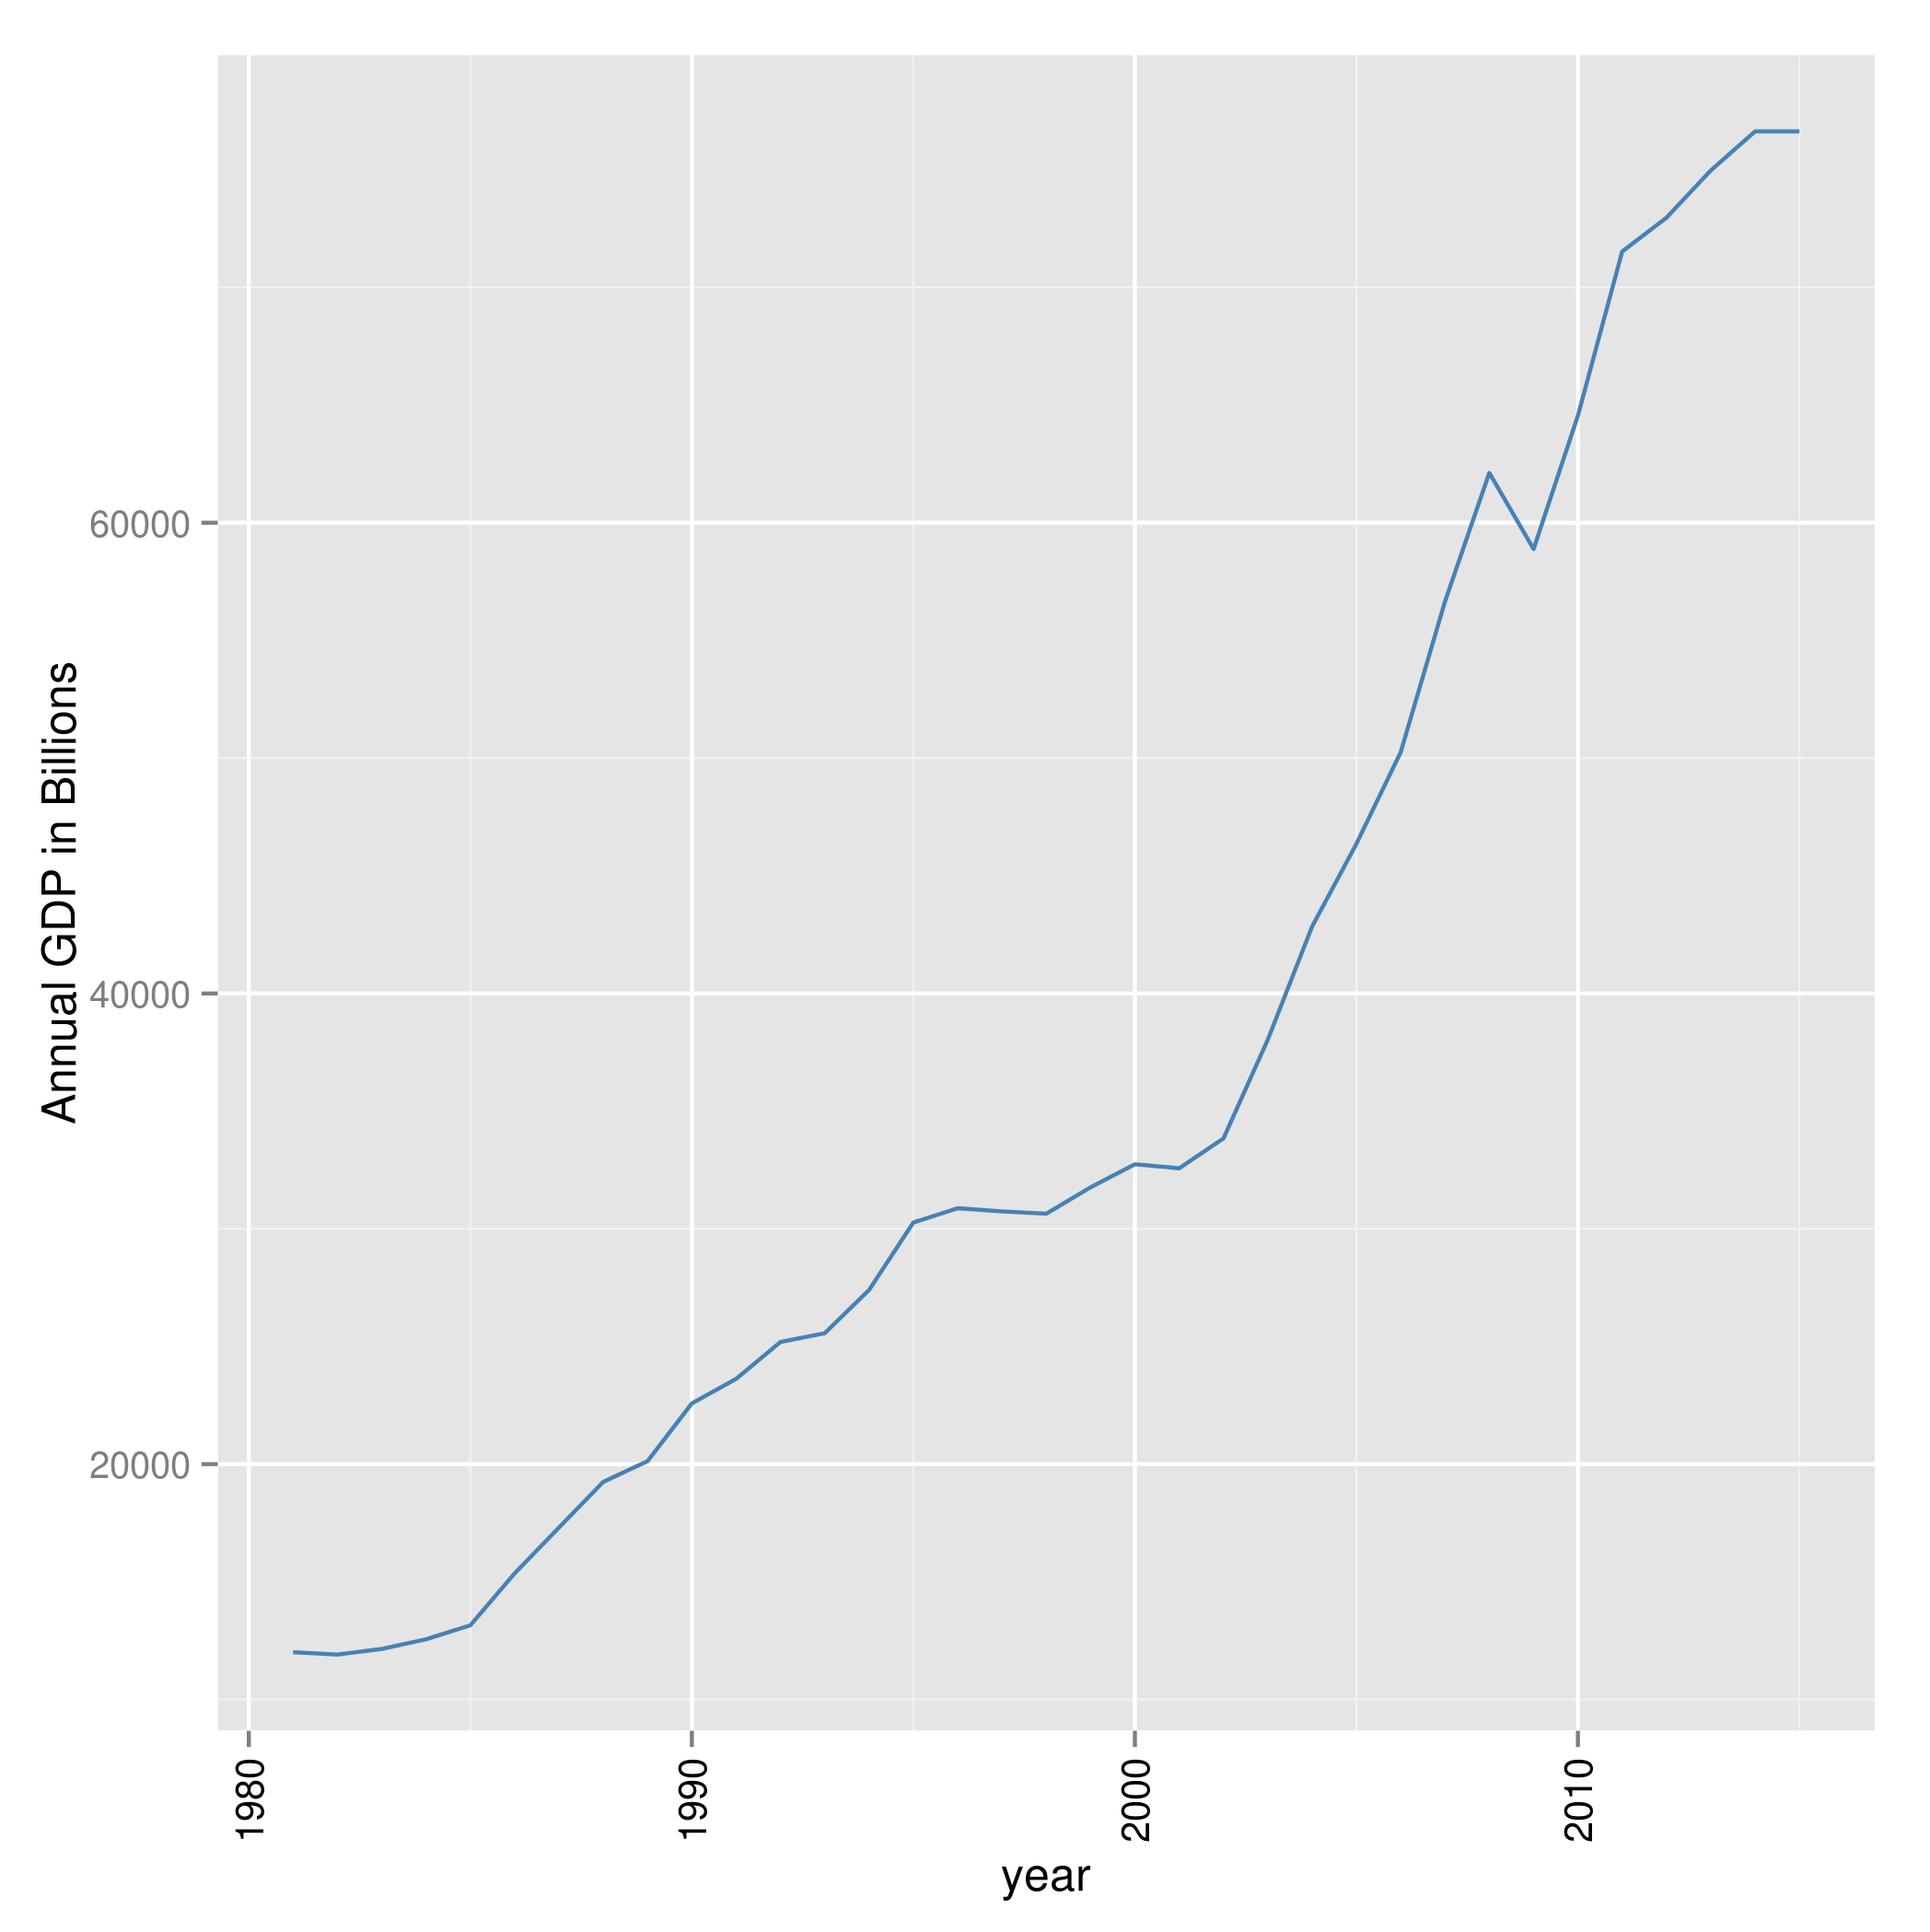

In [8]:
Image("gdp_total_by_year.png")

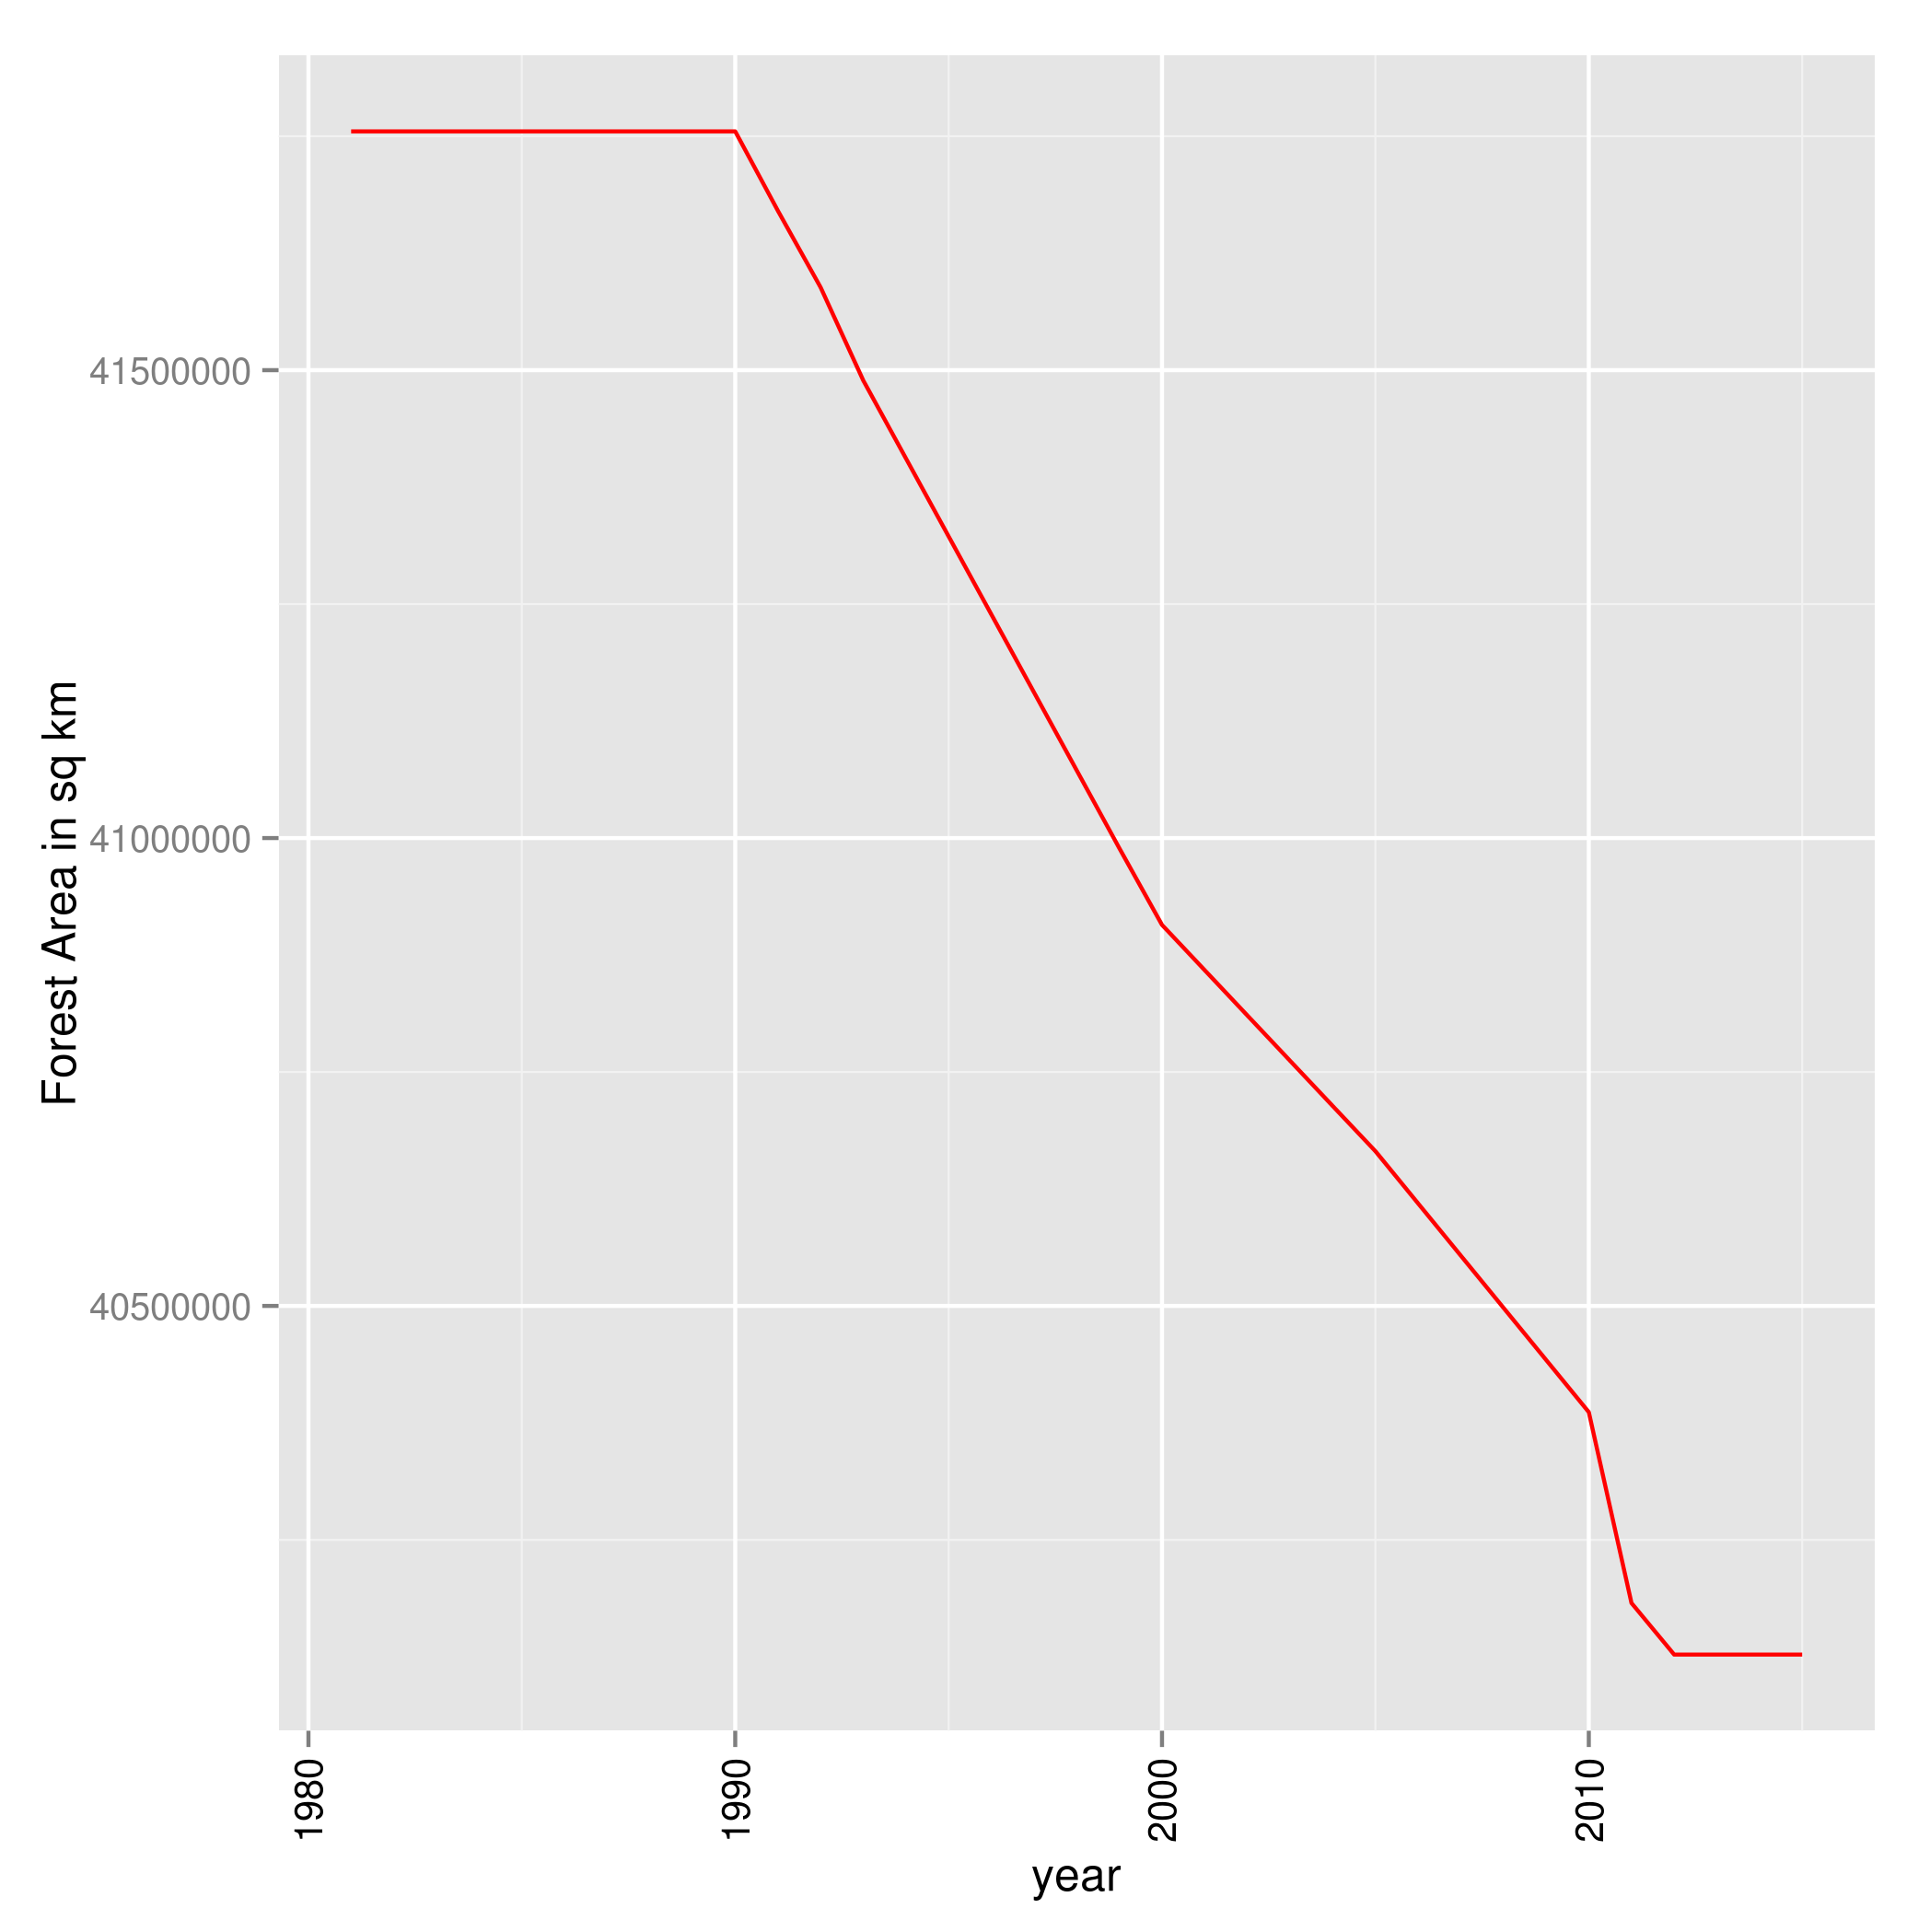

In [9]:
Image("forest_total_by_year.png")

### Analysis

In [10]:
#identify best 3 and worst 3 country in term of forest area change wtih respect to gdp changes
def Analyize(gdp_forest):
    cleaned_grs = gdp_forest.groupby("country")
    cnty_fr2gdp_slope35yr = []
    cnty_forest_changes = []
    gdp_forest_35yr_gr = cleaned_grs[["gdp","forest_area"]] 
    for name, group in gdp_forest_35yr_gr:
        country = gdp_forest_35yr_gr.get_group(name)
        value_changes = country[-1:].values - country[:1].values
        forest_change = value_changes[0][1]
        chg_35yr = value_changes /  country[:1].values #calucalte percentage change for 35 years
        slope_35yr = chg_35yr[0][1] / chg_35yr[0][0] #d forest / d gdp
        cnty_fr2gdp_slope35yr.append((name,slope_35yr ))
        cnty_forest_changes.append((name, forest_change))
    cnty_fr2gdp_slope35yr = pd.DataFrame(cnty_fr2gdp_slope35yr, columns = ['country', 'forest_chg_over_gdp_chg']) 
    cnty_forest_changes = pd.DataFrame(cnty_forest_changes, columns = ['country', 'forest_chg']) 
    cnty_fr2gdp_slope35yr.dropna(axis = 0, inplace = True) # some countries do not have gdp data
    cnty_forest_changes.dropna(axis = 0, inplace = True)
    cnty_fr2gdp_slope35yr.sort('forest_chg_over_gdp_chg', inplace = True)
    cnty_forest_changes.sort('forest_chg', inplace = True)
    #join with income data
    country_incomelvels = gdp_forest[['country', 'incomeLevel']].drop_duplicates()
    cnty_fr2gdp_slope35yr = cnty_fr2gdp_slope35yr.merge(country_incomelvels, left_on = 'country', right_on='country')
    chg_by_income_grs = cnty_fr2gdp_slope35yr.groupby('incomeLevel')
    best3_and_worst3 = pd.DataFrame()
    for name, group in chg_by_income_grs:
        gr = group.copy()
        gr.sort('forest_chg_over_gdp_chg', inplace = True)
        best3_and_worst3 = best3_and_worst3.append(gr[:3])
        best3_and_worst3 = best3_and_worst3.append(gr[-3:])
    return (best3_and_worst3, cnty_forest_changes)

best3_and_worst3, cnty_forest_changes = Analyize(gdp_forest)

#add rangking
def add_ranking(x):
    x['ranking'] = ['worst1', 'worst2', 'worst3', 'best3', 'best2', 'best1']
    return x
best3_and_worst3 = best3_and_worst3.groupby('incomeLevel').apply(add_ranking)

#add subplot title locations
best3_and_worst3["x"] = 2000
best3_and_worst3["y"] = np.inf

#retrive detail data
gdp_forest.drop('incomeLevel', axis=1, inplace=True) #prevent incomeLevel column duplicate
best3_and_worst3_detail = gdp_forest.merge(best3_and_worst3, right_on = 'country', left_on ="country")
    

### Plots

In [11]:
#plot ggplot
r_df_annotate = com.convert_to_r_dataframe(best3_and_worst3)
r_df_plot = com.convert_to_r_dataframe(best3_and_worst3_detail)
def createPlot(top3, country_labeldata, filename, x, y, color):
    gp = ggplot2.ggplot(data=top3)
    gp = gp + \
        ggplot2.geom_line(ggplot2.aes_string(x=x, y=y), color=color) + \
        ggplot2.facet_grid(ro.Formula('incomeLevel~ranking'), scale='free_y') + \
        ggplot2.theme(**{'axis.text.x' : ggplot2.element_text(angle = 90, hjust = 1),
                          'strip.text.y' : ggplot2.element_text(size = 6, angle=90)})  + \
        ggplot2.geom_text(ggplot2.aes_string(x='x', y='y',label='country'), data = country_labeldata, vjust=1, size=2) + \
        ggplot2.scale_y_continuous("GDP Growth vs Forest Area Change %" ) + \
        ggplot2.guides(fill = ggplot2.guide_legend())
    ggplot2.ggplot2.ggsave(filename, gp)

createPlot(r_df_plot, r_df_annotate, "gdp_by_income.png", 'year', 'gdp_angr', 'steelblue')
createPlot(r_df_plot, r_df_annotate, "forest_by_income.png", 'year', 'forest_pct_chg', 'red')


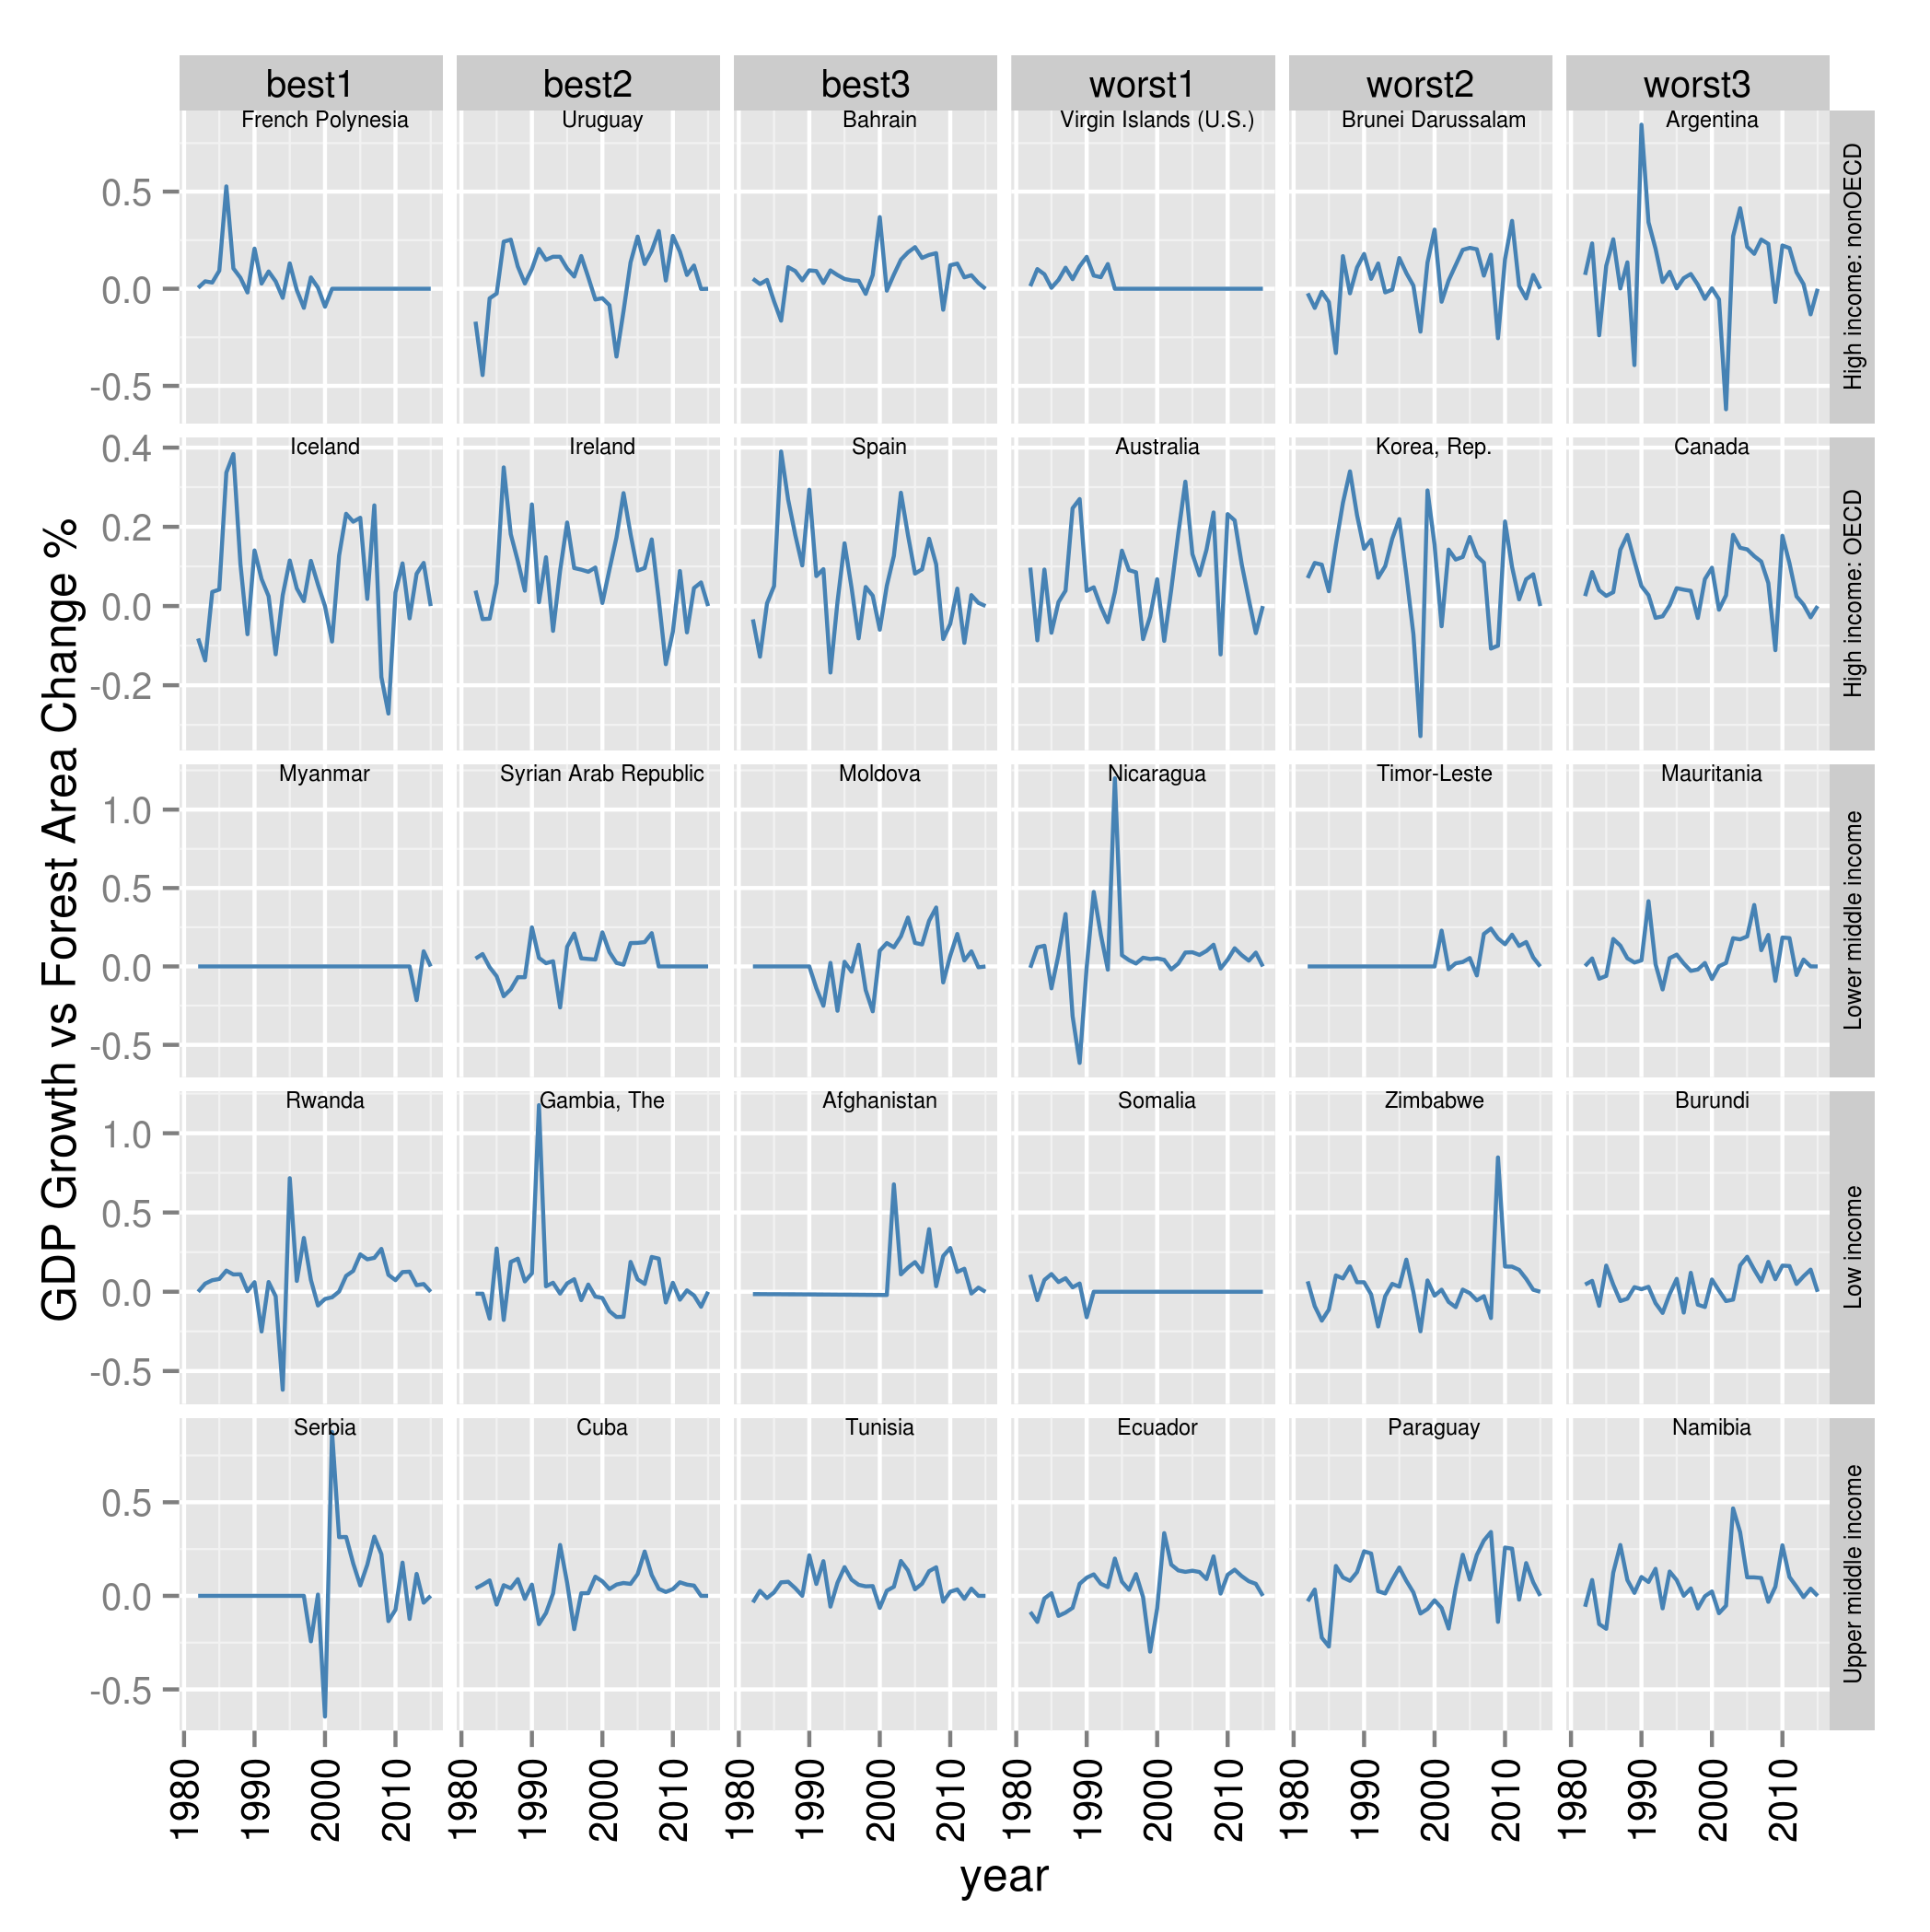

In [12]:
Image("gdp_by_income.png")
# Attention: scale_y for each row  are set to be different to see effects

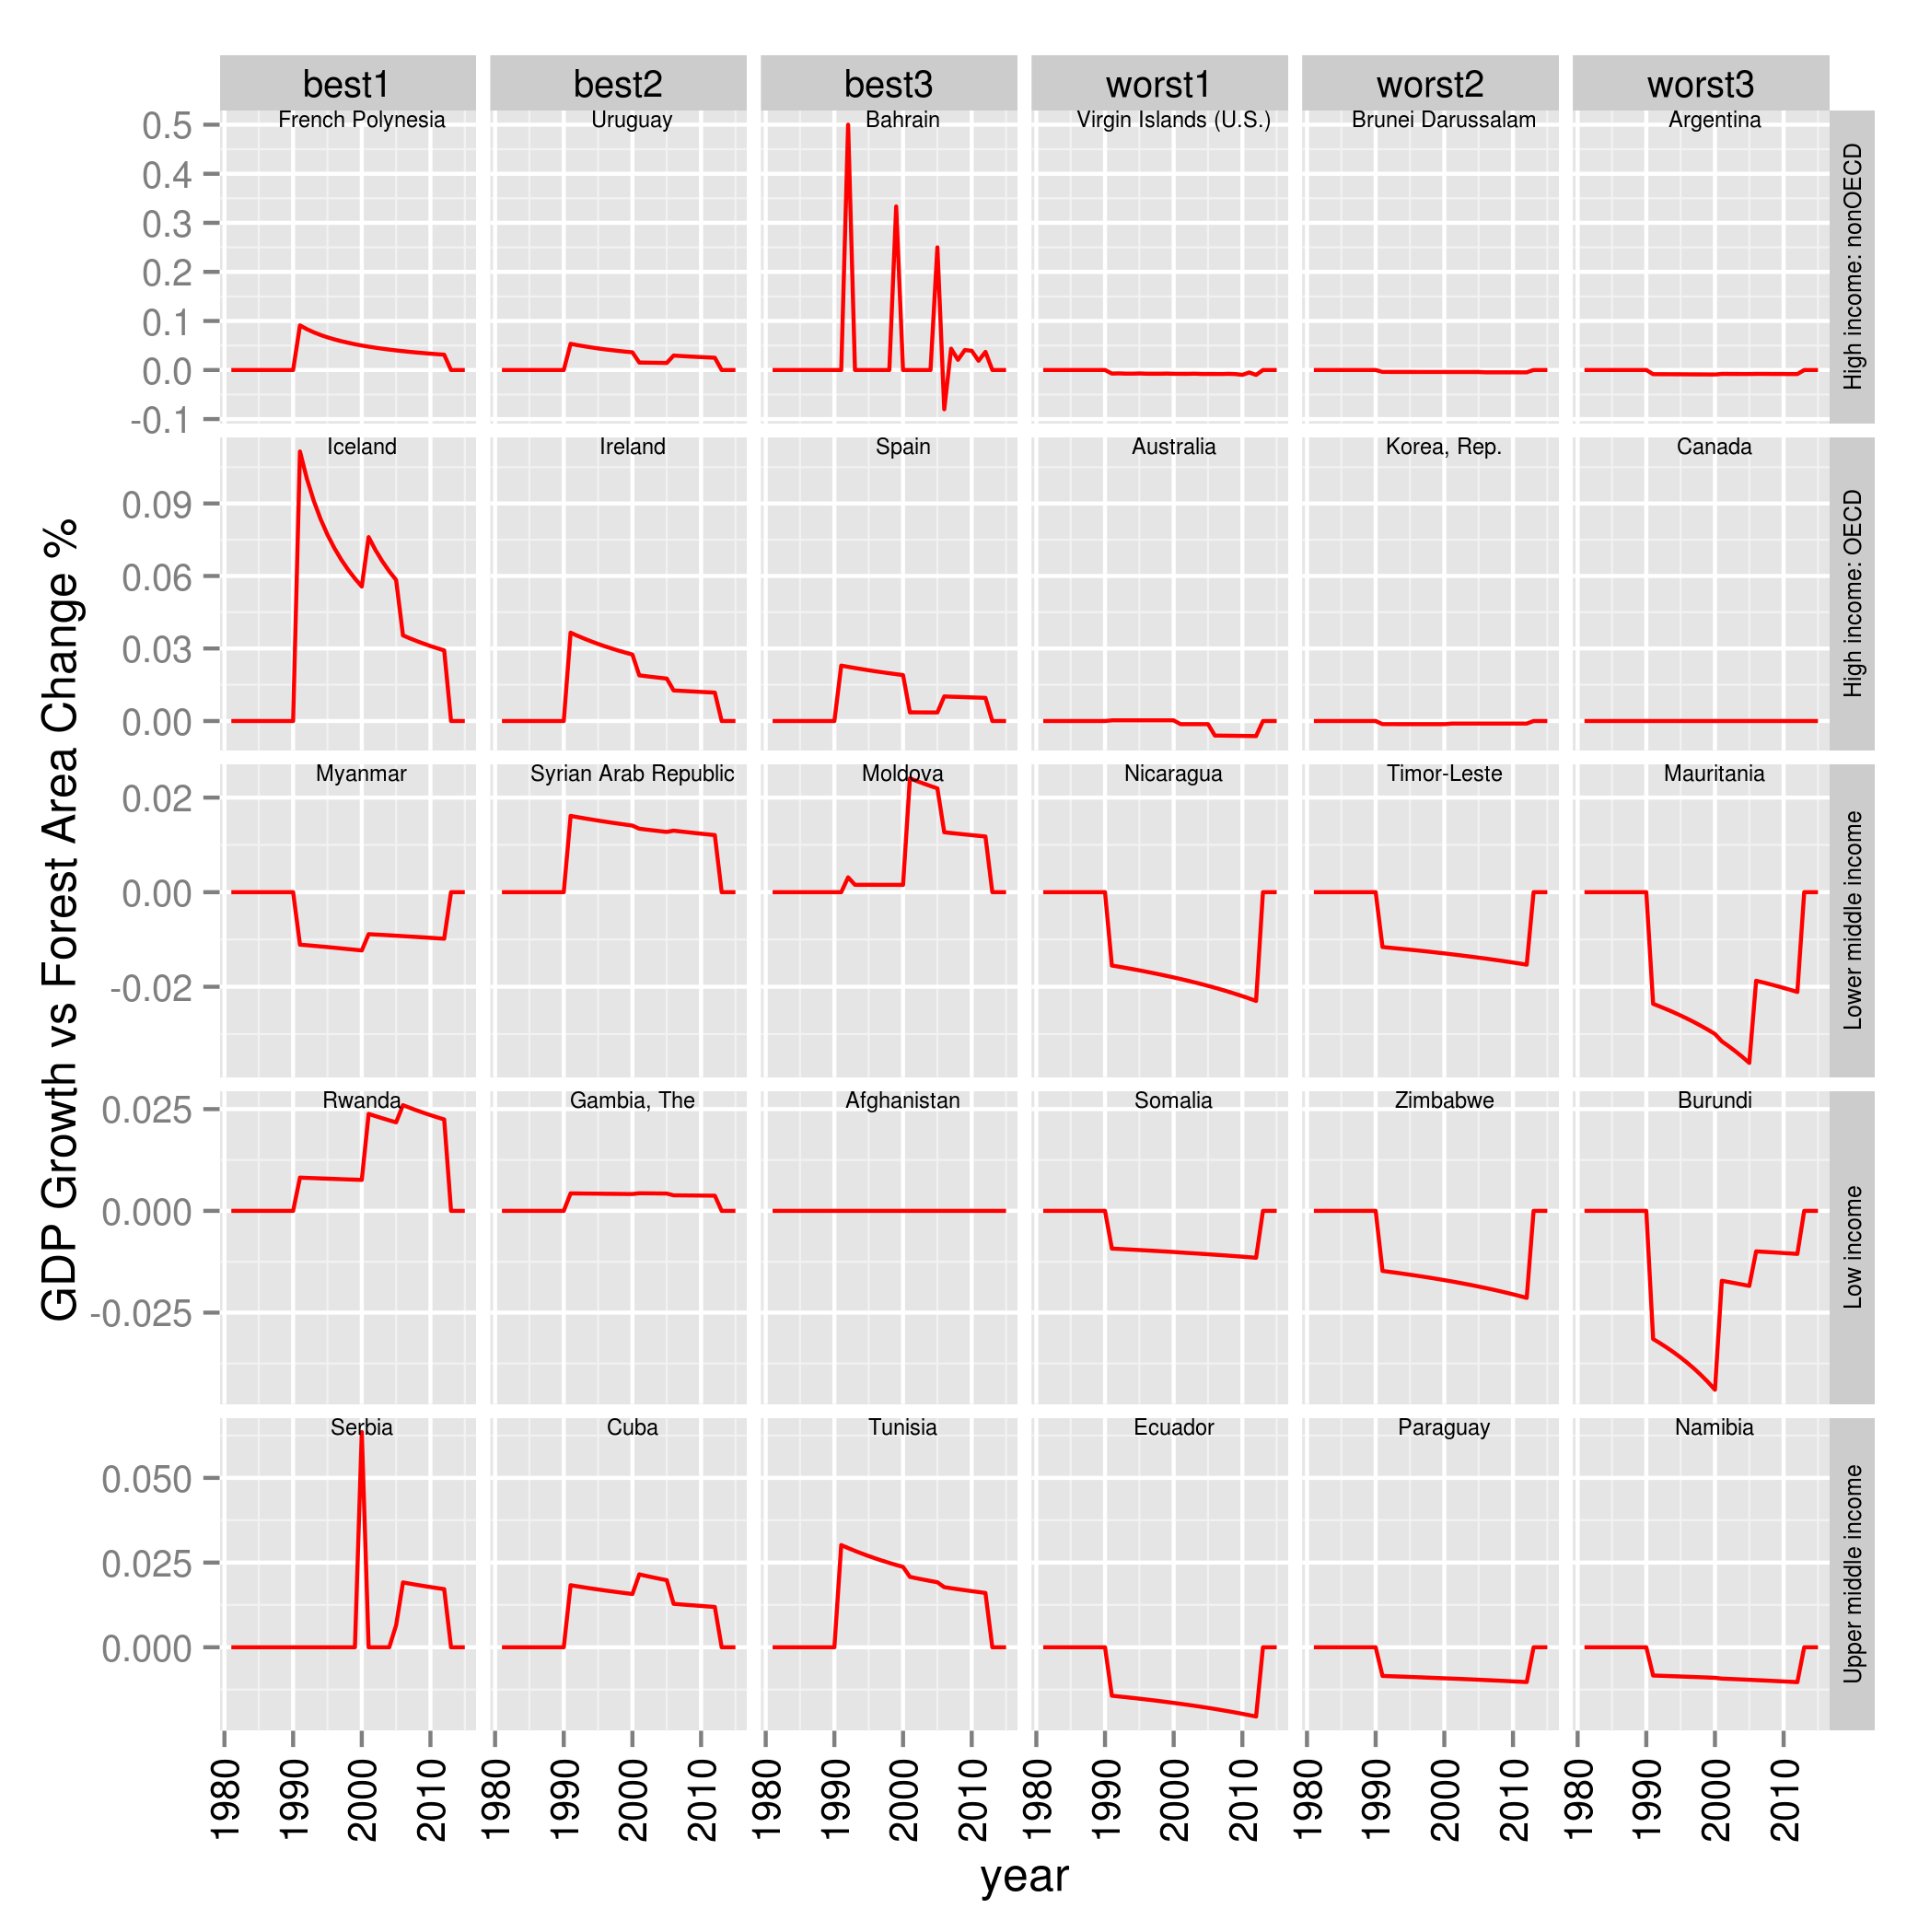

In [13]:
Image("forest_by_income.png")
# Attention: scale_y for each row  are set to be different to see effects

### Identify the worst regions in the world in term of forest-area lost

In [18]:
cnty_forest_changes.to_csv('cf.csv', index=False)
setwd ="setwd('" + os.getcwd() + "')"
ro.r(setwd)
ro.r.source("plotwmap.R") # youd need to install rworldmap package in R for it to work
ro.r("plotWmap()")

203 codes from your data successfully matched countries in the map
2 codes from your data failed to match with a country code in the map
41 codes from the map weren't represented in your data


<IntVector - Python:0x7f33e44aae60 / R:0x8a4ed88>
[       2]

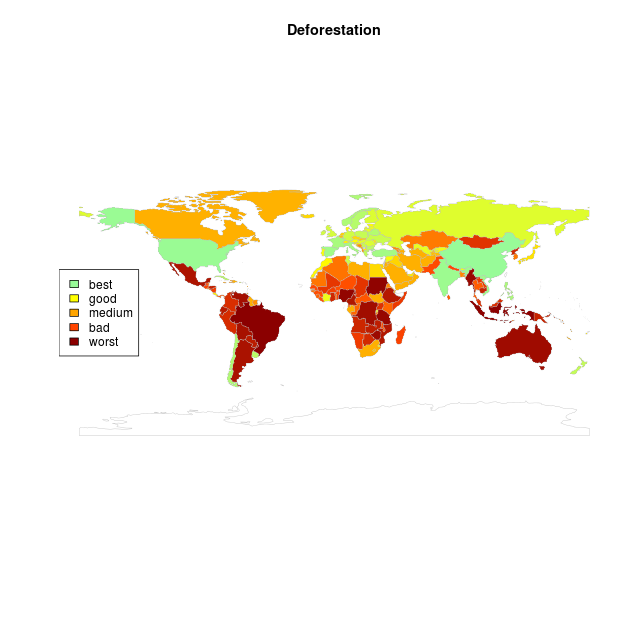

In [19]:
Image("wmap.png")

### Latin America, Africa, and South East Asia have the biggest deforestation problems.

In [17]:
#Print the worst 10 countries in term of forest-area lost
cnty_forest_changes.head(10)

,country,forest_chg
26,Brazil,-597058.0
85,Indonesia,-254830.0
177,Sudan,-213061.9
137,Nigeria,-90122.0
184,Tanzania,-88738.0
129,Myanmar,-80642.0
208,Zimbabwe,-71940.0
10,Australia,-70480.0
42,"Congo, Dem. Rep.",-68508.0
203,"Venezuela, RB",-63262.0


### Project the worst country's forest area in two years

In [204]:
#Project Brazil's forest area in two years
Brazil = gdp_forest[gdp_forest['country'] == 'Brazil']
#train a model to project Brazil's forest area in two years
regr = LinearRegression()
br_gdp = Brazil['gdp'].values
br_fr = Brazil['forest_area'].values
regr.fit(br_gdp[:, np.newaxis], br_fr)
#read gdp projection data
gdp_proj = pd.read_csv("gdp_projection.csv")
brazil_proj = gdp_proj[gdp_proj['Country Name'] == 'Brazil']
br_gdp_growth = np.vstack((brazil_proj['2016 [2016]'].values, brazil_proj['2017 [2017]'].values) )
#Brazil projected gdp in next two years 
br_gdp_proj =  (1 + br_gdp_growth / 100) * br_gdp[-1]
br_fr_proj = regr.predict(br_gdp_proj)
print "Brazil Projected Forest Areas for 2016 and 2017"
print "2016: {0:.2f} sq km".format(float(br_fr_proj[0]))
print "2017: {0:.2f} sq km".format(float(br_fr_proj[1]))

Brazil Projected Forest Areas for 2016 and 2017
2016: 5112091.94 sq km
2017: 5106517.30 sq km
